#Семинар. Регуляризация в линейной регрессии

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##Lasso-регрессия

In [3]:
def soft_sign(x, eps=1e-7):
    if abs(x) > eps:
        return np.sign(x)
    return x / eps

np_soft_sign = np.vectorize(soft_sign)



class MyLassoRegression(object):
    def __init__(self, C=1):
        self.coef_ = None
        self.intercept_ = None
        self.C = C
    
    def regularization_term(self, weights):
        signs = np_soft_sign(weights)
        signs[0] = 0
        return signs
    
    def grad(self, X, y, weights):
        basic_term = 1. / X.shape[0] * (X.T @ (X @ weights - y))
        regularization_term = self.regularization_term(weights)

        return basic_term + self.C * regularization_term

    def fit(self, X, y, max_iter=100, lr=0.1):

        X = np.array(X)
        y = np.array(y)

        X = np.hstack([np.ones([X.shape[0], 1]), X])

        l, n = X.shape

        weights = np.random.randn(n)

        losses = []

        for iter_num in range(max_iter):

            y_pred = (X @ weights.reshape(n, 1)).ravel()
            grad = self.grad(X, y, weights)
            weights -= grad * lr / ((iter_num + 1) ** 0.5)
            
            loss = np.mean((X @ weights - y) ** 2) + self.C * np.sum(np.abs(weights[1:]))
            losses.append(loss)
        
        self.coef_ = weights[1:]
        self.intercept_ = weights[0]

        return losses

    def predict(self, X):
        X = np.array(X)
        y_pred = X @ self.coef_ + self.intercept_

        return y_pred

In [4]:
def linear_expression(x):
    return 5 * x + 6

In [5]:
from sklearn.model_selection import train_test_split

objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

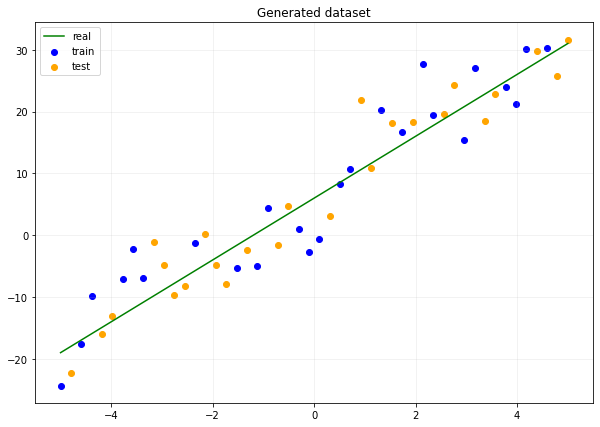

In [6]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title('Generated dataset')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [7]:
regressor = MyLassoRegression()

losses = regressor.fit(X_train[:, np.newaxis], y_train)

predictions = regressor.predict(X_test[:, np.newaxis])

In [8]:
regressor.coef_, regressor.intercept_

(array([4.75594884]), 5.817905366273354)

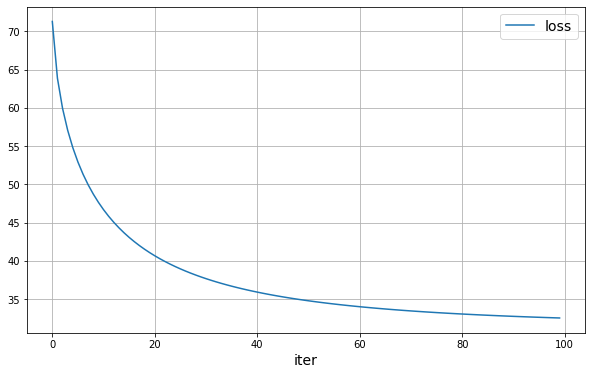

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

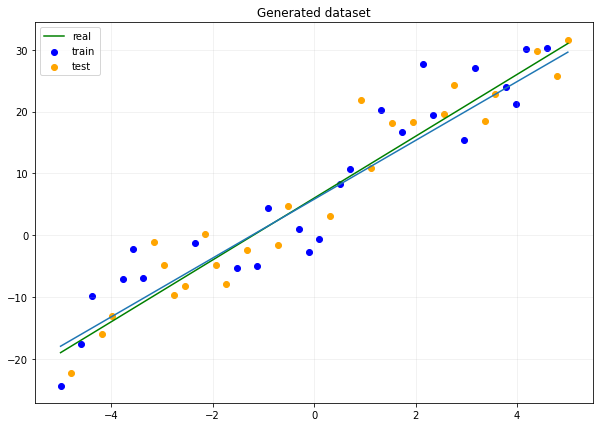

In [10]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.plot(X, regressor.predict(X[:, np.newaxis]))

plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title('Generated dataset')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

## Загрузка данных




In [11]:
import numpy as np
import pandas as pd

In [17]:
#т.к. набор данных удален в версии 1.2. следуем инструкции последовавшей из предупреждения после "from sklearn.datasets import load_boston"
raw_df = pd.read_csv("http://lib.stat.cmu.edu/datasets/boston", sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [21]:
X = pd.DataFrame(data)

In [31]:
y = pd.Series(target)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [34]:
model = MyLassoRegression(C=0.001)
losses = model.fit(X_train_scaled, y_train)

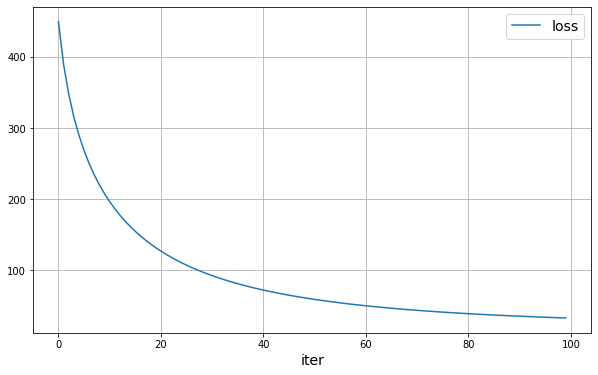

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

<BarContainer object of 13 artists>

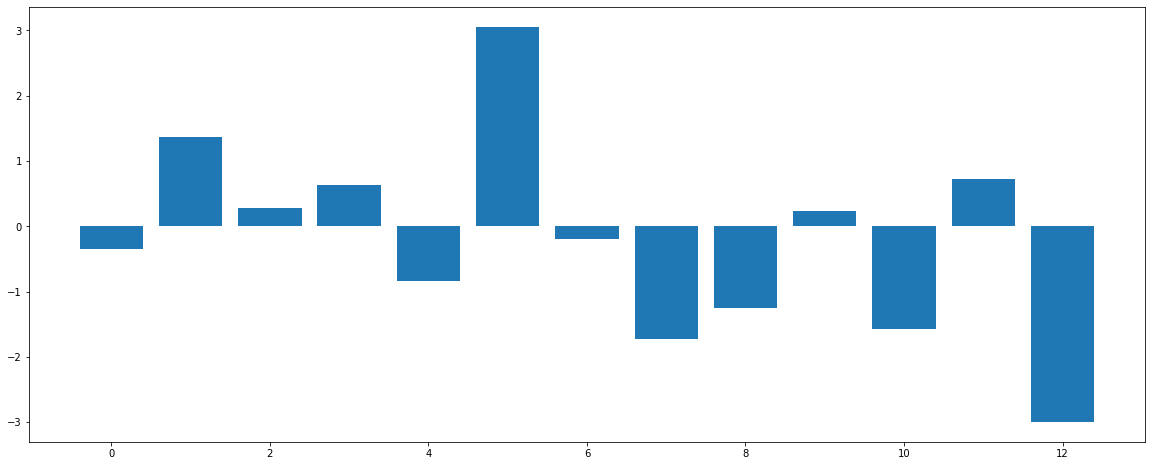

In [38]:
plt.figure(figsize=(20, 8))
plt.bar(X.columns, model.coef_)

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 

y_train_prediction = model.predict(X_train_scaled)
y_test_prediction = model.predict(X_test_scaled)

print(f'Train MSE: {mean_squared_error(y_train, y_train_prediction)}')
print(f'Test MSE: {mean_squared_error(y_test, y_test_prediction)}')

Train MSE: 33.30683281374792
Test MSE: 51.752275618624246


In [40]:
model.coef_, model.intercept_

(array([-0.35517977,  1.36716424,  0.28513548,  0.62709776, -0.84472808,
         3.05785232, -0.1960028 , -1.72368131, -1.25283018,  0.23586536,
        -1.57925383,  0.72957224, -2.99858969]), 18.911667081155173)

##Величина весов в зависимости от коэффицента регуляризации

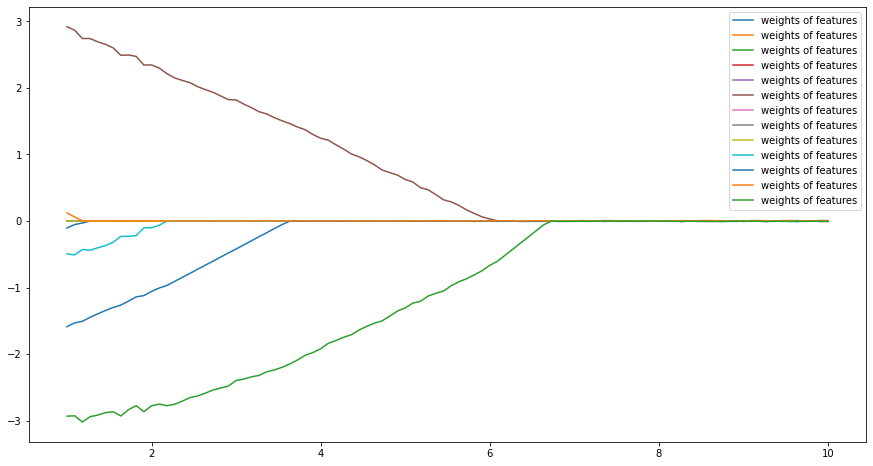

In [41]:
reg_coefs = np.linspace(1, 10, 100)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    lasso_regressor = MyLassoRegression(C=C)
    lasso_regressor.fit(X_train_scaled, y_train, lr=0.05, max_iter=10000)
    weights = np.hstack((weights, lasso_regressor.coef_.reshape(-1, 1)))

plt.figure(figsize=(15, 8))
plt.plot(reg_coefs, weights.T, label='weights of features')
plt.legend()
plt.show()

In [42]:
from sklearn.linear_model import Lasso

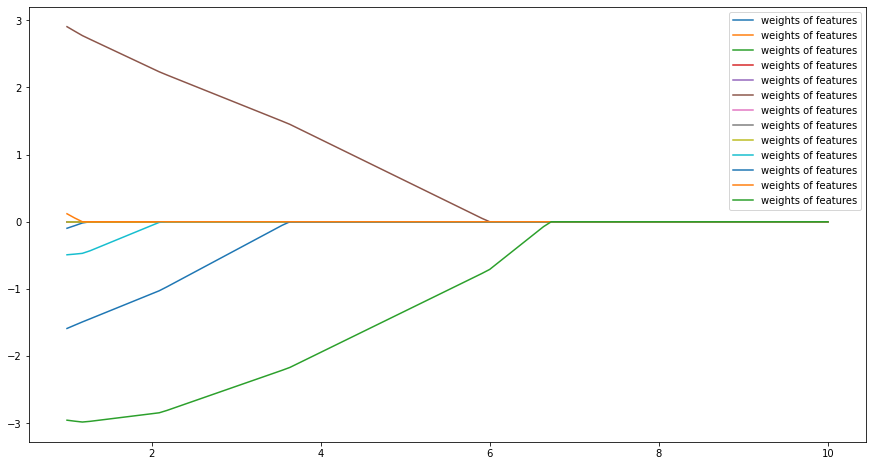

In [43]:
reg_coefs = np.linspace(1, 10, 100)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    lasso_regressor = Lasso(alpha=C)
    lasso_regressor.fit(X_train_scaled, y_train)
    weights = np.hstack((weights, lasso_regressor.coef_.reshape(-1, 1)))

plt.figure(figsize=(15, 8))
plt.plot(reg_coefs, weights.T, label='weights of features')
plt.legend()
plt.show()

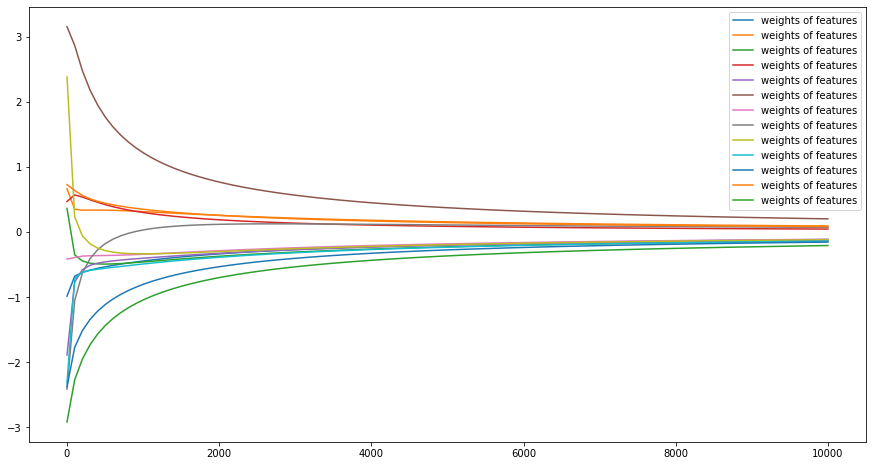

In [47]:
from sklearn.linear_model import Ridge


reg_coefs = np.linspace(1, 10000, 100)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    ridge_regressor = Ridge(C)
    ridge_regressor.fit(X_train_scaled, y_train)
    weights = np.hstack((weights, ridge_regressor.coef_.reshape(-1, 1)))

plt.figure(figsize=(15, 8))
plt.plot(reg_coefs, weights.T, label='weights of features')
plt.legend()
plt.show()